In [1]:
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install tqdm

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV3Small

2024-12-10 02:10:26.716693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 02:10:26.737597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 02:10:26.743885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 02:10:26.759611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
DATASET_NAME = "organmnist3d"
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (180, 96, 96, 3)
INPUT_SHAPE_2D = (96, 96, 3)
MAX_FRAMES = 180
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4

# TRAINING
EPOCHS = 30
DATA_NUM = 500

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 12

# MOBILENETV3
MOBILENET_NUM_LAYER = 40

In [4]:
def load_video(path, max_frames=MAX_FRAMES, resize=(96, 96), dtype=np.float16):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or frame_count >= max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize)
            frames.append(frame.astype(dtype))
            frame_count += 1
    finally:
        cap.release()

    while len(frames) < max_frames:
        frames.append(frames[-1].astype(dtype) if frames else np.zeros(resize + (3,), dtype=dtype))

    return np.array(frames)

In [5]:
def prepare_dataset(folder_path):
    class_names = ["NonViolence", "Violence"]
    x, y = [], []
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        video_cnt = 0
        print(f"Processing {class_name} videos...")
        
        for video_file in tqdm(os.listdir(class_folder)):
            if video_cnt >= DATA_NUM:
                break
            video_path = os.path.join(class_folder, video_file)
            frames = load_video(video_path)
            x.append(frames)
            y.append(class_index)
            video_cnt += 1

    return np.array(x), keras.utils.to_categorical(y, num_classes=len(class_names))

In [6]:
class MobileNetV3FeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, num_frames, **kwargs):
        super().__init__(**kwargs)
        self.num_frames = num_frames

        self.mobilenetv3 = MobileNetV3Small(
            input_shape=INPUT_SHAPE_2D, 
            include_top=False, 
            weights='imagenet'
        )
        self.reduced_mobilenetv3_model = tf.keras.Model(
            inputs=self.mobilenetv3.input,
            outputs=self.mobilenetv3.layers[MOBILENET_NUM_LAYER].output
        )

        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(PROJECTION_DIM)

    def call(self, inputs):
        frames = tf.split(inputs, num_or_size_splits=self.num_frames, axis=1)
        frame_features = [
            self.dense(self.pooling(self.reduced_mobilenetv3_model(tf.squeeze(frame, axis=1))))
            for frame in frames
        ]
        features = tf.stack(frame_features, axis=1)
        return features

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [7]:
def create_vivit_model(
    feature_extractor,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    inputs = layers.Input(shape=input_shape)
    features = feature_extractor(inputs)
    encoded_patches = positional_encoder(features)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    representation = layers.Dropout(0.1)(representation)

    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    return keras.Model(inputs=inputs, outputs=outputs)

In [8]:
print("Loading dataset...")
dataset_path = "Real Life Violence Dataset"
x, y = prepare_dataset(dataset_path)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1, random_state=123)

Loading dataset...
Processing NonViolence videos...


 44%|████▍     | 441/1000 [00:40<00:45, 12.20it/s][h264 @ 0x564417c3ae80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x564417c3ae80] error while decoding MB 98 31
 50%|█████     | 500/1000 [00:46<00:46, 10.69it/s]


Processing Violence videos...


 50%|█████     | 500/1000 [01:16<01:16,  6.56it/s]


In [9]:
print("Creating model...")
model = create_vivit_model(
    feature_extractor=MobileNetV3FeatureExtractor(num_frames=MAX_FRAMES),
    positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
)

Creating model...


/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1733796759.162507   53326 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733796759.177358   53326 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733796759.180627   53326 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least o

In [10]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.6, patience=5,
    min_lr=0.00005, verbose=1
)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

2024-12-10 02:13:32.713502: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8957952000 exceeds 10% of free system memory.
2024-12-10 02:13:38.391501: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8957952000 exceeds 10% of free system memory.


In [12]:
print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

Training model...
Epoch 1/30


2024-12-10 02:13:43.706020: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8957952000 exceeds 10% of free system memory.
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bia

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.8943 - precision: 0.5267 - recall: 0.5267

2024-12-10 02:43:34.662984: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1859', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8090', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_1', 108 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion', 248 bytes spill stores, 352 bytes spill loads

2024-12-10 02:43:40.253222: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m15.492912624s

********************************
[Compiling module a_inference_one_step_on_data_573941__.682255] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*********************

113/113 ━━━━━━━━━━━━━━━━━━━━ 1799s 6s/step - loss: 0.8920 - precision: 0.5273 - recall: 0.5273 - learning_rate: 1.0000e-04
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - loss: 0.6777 - precision: 0.6108 - recall: 0.6108 - learning_rate: 1.0000e-04
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - loss: 0.6043 - precision: 0.6736 - recall: 0.6736 - learning_rate: 1.0000e-04
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - loss: 0.5753 - precision: 0.6887 - recall: 0.6887 - learning_rate: 1.0000e-04
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - loss: 0.5163 - precision: 0.7379 - recall: 0.7379 - learning_rate: 1.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - loss: 0.4752 - precision: 0.7469 - recall: 0.7469 - learning_rate: 1.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - loss: 0.4545 - precision: 0.7687 - recall: 0.7687 - learning_rate: 1.0000e-04
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - loss: 0.45

In [ ]:
print("Evaluating model...")
ts_loss, ts_precision, ts_recall = model.evaluate(test_dataset)
print(f"Test Loss: {ts_loss}")
print(f"Test Precision: {ts_precision}")
print(f"Test Recall: {ts_recall}")

f1_score = 2 * (ts_precision * ts_recall) / (ts_precision + ts_recall)
print(f"F1 Score: {f1_score}")

Evaluating model...


2024-12-10 02:58:48.284960: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_1', 108 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_14', 248 bytes spill stores, 352 bytes spill loads



12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.6214 - precision: 0.8912 - recall: 0.8912

2024-12-10 03:00:15.918636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_1', 108 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_14', 248 bytes spill stores, 352 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - loss: 0.6633 - precision: 0.8868 - recall: 0.8868
Test Loss: 0.9150133728981018
Test Precision: 0.8600000143051147
Test Recall: 0.8600000143051147
F1 Score: 0.8600000143051147


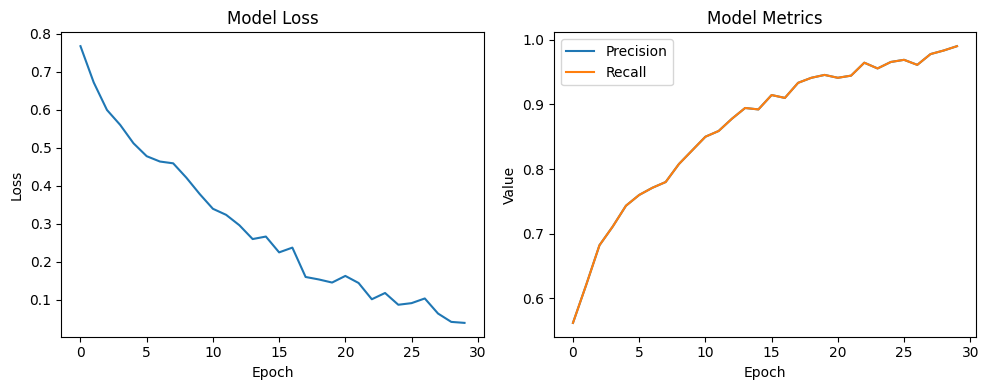

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Precision', 'Recall'])
plt.tight_layout()
plt.show()